In [1]:
import pickle
import numpy as np

In [2]:
with open('train_qa.txt', 'rb') as f:
    train_data = pickle.load(f)

In [3]:
with open('test_qa.txt', 'rb') as f:
    test_data = pickle.load(f)

In [208]:
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [5]:
len(train_data), len(test_data)

(10000, 1000)

In [6]:
' '.join(train_data[0][0])

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [7]:
' '.join(train_data[0][1])

'Is Sandra in the hallway ?'

In [8]:
train_data[0][2]

'no'

In [9]:
all_data = test_data + train_data

In [10]:
len(all_data)

11000

In [11]:
vocab = set()

for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))
len(vocab)

35

In [12]:
vocab = vocab.union(set(['yes', 'no']))

In [13]:
vocab_len = len(vocab) + 1  #one extra for keras pad-sequences placeholder

In [14]:
vocab_len

38

In [15]:
# LONGEST STORY
all_story_lengths = [len(data[0]) for data in all_data]

# LONGEST QUESTION
all_ques_lengths = [len(data[1]) for data in all_data]

In [16]:
max_story_len = max(all_story_lengths)

In [17]:
max_story_len

156

In [18]:
max_ques_len = max(all_ques_lengths)

In [19]:
max_ques_len

6

In [20]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [21]:
tokenizer = Tokenizer(filters=[])  # default fiter is not required

In [22]:
tokenizer.fit_on_texts(vocab)

In [23]:
tokenizer.texts_to_sequences(all_data[0])

[[6, 35, 20, 16, 1, 33, 3, 10, 26, 20, 5, 33], [22, 3, 13, 20, 32, 29], [23]]

In [24]:
tokenizer.word_index

{'there': 1,
 'hallway': 2,
 'john': 3,
 'bathroom': 4,
 'bedroom': 5,
 'mary': 6,
 'office': 7,
 'went': 8,
 'picked': 9,
 'moved': 10,
 'dropped': 11,
 'discarded': 12,
 'in': 13,
 'took': 14,
 'back': 15,
 'milk': 16,
 'grabbed': 17,
 'down': 18,
 'apple': 19,
 'the': 20,
 'yes': 21,
 'is': 22,
 'no': 23,
 'football': 24,
 'up': 25,
 'to': 26,
 'journeyed': 27,
 'sandra': 28,
 '?': 29,
 'left': 30,
 'garden': 31,
 'kitchen': 32,
 '.': 33,
 'put': 34,
 'got': 35,
 'daniel': 36,
 'travelled': 37}

In [32]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_ques_len=max_ques_len):
    X = []
    Xq = []
    Y = []
    
    for story, question, answer in data:
        x = [word_index[word.lower()] for word in story]
        xq = [word_index[word.lower()] for word in question]
        y = np.zeros(len(word_index) + 1)
        
        y[word_index[answer]] = 1
        
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    return (pad_sequences(X, maxlen=max_story_len), pad_sequences(Xq, maxlen=max_ques_len), np.array(Y))

In [33]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [34]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [35]:
inputs_train

array([[ 0,  0,  0, ..., 20,  5, 33],
       [ 0,  0,  0, ..., 20,  2, 33],
       [ 0,  0,  0, ..., 20,  4, 33],
       ...,
       [ 0,  0,  0, ..., 20,  5, 33],
       [ 0,  0,  0, ..., 16,  1, 33],
       [ 0,  0,  0, ..., 19,  1, 33]])

In [42]:
sum(answers_test), len(answers_test)

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 497.,
          0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.]), 1000)

In [37]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Dense, LSTM, Input, Activation, Permute, Dropout, add, dot, concatenate

In [39]:
# PLCEHOLDER shape=(max_story_len, batch_size)
input_sequence = Input((max_story_len, ))
question = Input((max_ques_len, ))

In [ ]:
# SAME AS vocab_len
vocab_size = len(vocab) + 1

In [43]:
vocab_size

38

In [46]:
# INPUT ENCODER M
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size, output_dim=64))
input_encoder_m.add(Dropout(0.3))

# OUTPUT
# (samples, max_len_story, embedding_dim)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [48]:
# INPUT ENCODER C
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=max_ques_len))
input_encoder_m.add(Dropout(0.3))

# OUTPUT
# (samples, max_len_story, max_ques_len)

In [49]:
# QUESTION ENCODER
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size, output_dim=64))
question_encoder.add(Dropout(0.3))

# OUTPUT
# (samples, max_len_story, embedding_dim)

In [ ]:
# ENCODED <--- ENCODER(INPUT)
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

In [57]:
input_encoded_m, question_encoded, input_encoded_c

(<tf.Tensor 'sequential_3/dropout_2/cond/Merge:0' shape=(?, 156, 64) dtype=float32>,
 <tf.Tensor 'sequential_6/dropout_3/cond/Merge:0' shape=(?, 6, 64) dtype=float32>,
 <tf.Tensor 'sequential_5/embedding_2/embedding_lookup/Identity:0' shape=(?, 156, 6) dtype=float32>)

In [55]:
# calculating match between m (Embedding A) and q (Embedding B)

match = dot([input_encoded_m, question_encoded], axes=(2,2))
match = Activation('softmax')(match)

In [56]:
match

<tf.Tensor 'activation_1/truediv:0' shape=(?, 156, 6) dtype=float32>

In [58]:
response = add([input_encoded_c, match])
response = Permute((2, 1))(response)

In [59]:
response

<tf.Tensor 'permute_1/transpose:0' shape=(?, 6, 156) dtype=float32>

In [65]:
answer = concatenate([response, question_encoded])

In [66]:
answer

<tf.Tensor 'concatenate_2/concat:0' shape=(?, 6, 220) dtype=float32>

In [67]:
answer = LSTM(32)(answer)

In [63]:
answer = Dropout(0.5)(answer)

In [68]:
answer = Dense(vocab_size)(answer) # (samples, vocab_size) YES/NO

In [69]:
answer

<tf.Tensor 'dense_1/BiasAdd:0' shape=(?, 38) dtype=float32>

In [70]:
answer = Activation('softmax')(answer)

In [71]:
model = Model([input_sequence, question], answer)

In [72]:
model.compile(optimizer='rmsprop', loss="categorical_crossentropy", metrics=['accuracy'])

In [73]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 156)          0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 6)            0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       multiple             2432        input_2[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       multiple             2432        input_3[0][0]                    
__________________________________________________________________________________________________
dot_1 (Dot

In [75]:
history = model.fit([inputs_train, queries_train], answers_train, batch_size=32, epochs=100, validation_data=([inputs_test, queries_test], answers_test))

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 10000 samples, validate on 1000 samples
Epoch 1/100
10000/10000 [==============================] - 12s 1ms/step - loss: 0.8191 - acc: 0.4975 - val_loss: 0.6940 - val_acc: 0.4970
Epoch 2/100
10000/10000 [==============================] - 8s 780us/step - loss: 0.6950 - acc: 0.4974 - val_loss: 0.7211 - val_acc: 0.5030
Epoch 3/100
10000/10000 [==============================] - 8s 783us/step - loss: 0.6955 - acc: 0.5014 - val_loss: 0.6932 - val_acc: 0.4830
Epoch 4/100
10000/10000 [==============================] - 8s 785us/step - loss: 0.6948 - acc: 0.5051 - val_loss: 0.6942 - val_acc: 0.5030
Epoch 5/100
10000/10000 [==============================] - 8s 789us/step - loss: 0.6953 - acc: 0.4951 - val_loss: 0.6936 - val_acc: 0.5030
Epoch 6/100
10000/10000 [==============================] - 8s 789us/step - loss: 0.6951 - acc: 0.5012 - val_loss: 0.6935 - val_acc:

10000/10000 [==============================] - 8s 807us/step - loss: 0.2329 - acc: 0.8984 - val_loss: 0.4155 - val_acc: 0.8280
Epoch 56/100
10000/10000 [==============================] - 8s 811us/step - loss: 0.2279 - acc: 0.8984 - val_loss: 0.4327 - val_acc: 0.8310
Epoch 57/100
10000/10000 [==============================] - 8s 800us/step - loss: 0.2188 - acc: 0.9053 - val_loss: 0.4571 - val_acc: 0.8310
Epoch 58/100
10000/10000 [==============================] - 8s 806us/step - loss: 0.2180 - acc: 0.9037 - val_loss: 0.4479 - val_acc: 0.8190
Epoch 59/100
10000/10000 [==============================] - 8s 796us/step - loss: 0.2132 - acc: 0.9064 - val_loss: 0.4669 - val_acc: 0.8280 0.215 - ETA: 1s - lo
Epoch 60/100
10000/10000 [==============================] - 8s 796us/step - loss: 0.2092 - acc: 0.9100 - val_loss: 0.4695 - val_acc: 0.8230
Epoch 61/100
10000/10000 [==============================] - 8s 797us/step - loss: 0.2073 - acc: 0.9121 - val_loss: 0.4580 - val_acc: 0.8160
Epoch 62/100

In [76]:
model.save('my_trained_model.h5')

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


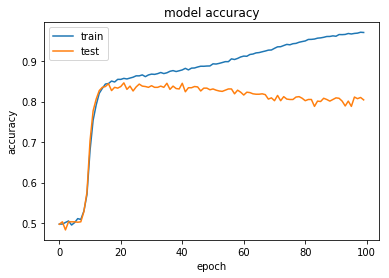

In [77]:
import matplotlib.pyplot as plt

print(history.history.keys())
#Summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [171]:
model.load_weights('my_trained_model.h5')

In [172]:
pred_results = model.predict(([inputs_test, queries_test]))

In [173]:
val_max = np.argmax(pred_results[0])

In [174]:
for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

In [175]:
k

'no'

In [176]:
pred_results[0][val_max]

0.9999976

In [177]:
# NOW WE'LL TEST THE MODEL WITH OUR VERY OWN STORY
#NOTE: As the model has been trained on the vocab of just 38 words, we'll have to create the story with the words in vocab

vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [201]:
my_story = "Mary journeyed to the kitchen . Mary picked apple . Daniel journeyed to the bedroom ."
my_ques = "Is Daniel in the bedroom ?"

In [202]:
mydata = [(my_story.split(), my_ques.split(), 'yes')]

In [203]:
mydata

[(['Mary',
   'journeyed',
   'to',
   'the',
   'kitchen',
   '.',
   'Mary',
   'picked',
   'apple',
   '.',
   'Daniel',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'Daniel', 'in', 'the', 'bedroom', '?'],
  'yes')]

In [204]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [205]:
pred_ans = model.predict(([my_story, my_ques]))

In [206]:
val_max = np.argmax(pred_ans)

In [207]:
#Generate prediction from model
val_max = np.argmax(pred_ans[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  2.3639561e-06
